### 0. 导入库

In [ ]:
import gym
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
import matplotlib.pyplot as plt

### 1. 建立用于拟合Q的DNN

In [ ]:
class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepQNetwork, self).__init__()

        # 建立3层的神经网络
        self.fc1 = nn.Linear(*input_dims, 128)
        # 添加dropout层，随机丢弃比例20%
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, 128)
        # 添加dropout层，随机丢弃比例20%
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(128, n_actions)

        # 用AdamW进行优化
        self.optimizer = optim.AdamW(self.parameters(), lr=lr)
        # 用MSELoss进行损失计算
        self.loss = nn.MSELoss()
        self.device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        # 用leaky_relu作为激活函数
        layer1 = F.leaky_relu(self.fc1(state), negative_slope=0.01)
        layer1 = self.dropout1(layer1)
        layer2 = F.leaky_relu(self.fc2(layer1), negative_slope=0.01)
        layer2 = self.dropout2(layer2)
        # 输出各 actions 的Q值
        actions = self.fc3(layer2)
        return actions

### 2. 建立利用DNN的Agent

In [ ]:
class Agent:
    def __init__(
        self,
        input_dims,
        n_actions,
        lr,
        gamma=0.99,
        epsilon=1.0,
        ep_dec=1e-5,
        ep_min=0.01,
    ):
        # 初始化Agent
        # 学习率
        self.lr = lr
        # 输入维度
        self.input_dims = input_dims
        # 动作维度
        self.n_actions = n_actions
        # 折扣因子
        self.gamma = gamma
        # epsilon
        self.epsilon = epsilon
        # epsilon衰减
        self.eps_dec = ep_dec
        # epsilon最小值
        self.eps_min = ep_min
        # 动作空间
        self.n_action_space = [i for i in range(n_actions)]
        # 初始化Q网络
        self.Q = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

    def choose_action(self, observation):
        # 用epsilon-greedy策略选择动作
        if np.random.random() > self.epsilon:
            state = T.tensor(observation, dtype=T.float).to(self.Q.device)
            actions = self.Q.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.n_action_space)

        return action

    def decrement_epsilon(self):
        self.epsilon = (
            self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        )

    def learn(self, state, action, reward, state_):
        # 梯度清零
        self.Q.optimizer.zero_grad()
        # 当前状态
        cur_state = T.tensor(state, dtype=T.float).to(self.Q.device)
        # 当前动作
        cur_action = T.tensor(action).to(self.Q.device)
        # 当前奖励
        cur_reward = T.tensor(reward).to(self.Q.device)
        # 下一状态
        next_states = T.tensor(state_, dtype=T.float).to(self.Q.device)
        # 当前状态的Q值
        q_pred = self.Q.forward(cur_state)[cur_action]
        # 下一状态的Q值
        q_next = self.Q.forward(next_states).max()
        # 目标Q值
        q_target = cur_reward + self.gamma * q_next
        # 计算损失
        loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
        # 反向传播
        loss.backward()
        # 更新参数
        self.Q.optimizer.step()
        # epsilon衰减
        self.decrement_epsilon()

### 3. 绘制学习曲线 

In [ ]:
def plot_learning_curve(x, scores, eps_history, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, eps_history, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis="x", colors="C0")
    ax.tick_params(axis="y", colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t - 100) : (t + 1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel("Score", color="C1")
    ax2.yaxis.set_label_position("right")
    ax2.tick_params(axis="y", colors="C1")

    # plt.savefig(filename)
    return plt

### 4. 创建训练环境

In [ ]:
env = gym.make("CartPole-v1")

In [ ]:
# 简单测试看看环境的交互数据结构
agent = Agent(
    input_dims=env.observation_space.shape, n_actions=env.action_space.n, lr=0.0001
)
obs = env.reset()
action = agent.choose_action(obs)
obs_, reward, terminated, truncated, info = env.step(action)
obs[0], action, obs_, reward, terminated, truncated, info

(array([-0.00490873, -0.01135814,  0.01391778, -0.01364402], dtype=float32),
 0,
 array([-0.00513589, -0.2066769 ,  0.0136449 ,  0.28339744], dtype=float32),
 1.0,
 False,
 False,
 {})

### 5. 正式训练

In [ ]:
env = gym.make("CartPole-v1")
agent = Agent(
    input_dims=env.observation_space.shape, n_actions=env.action_space.n, lr=0.0001
)
n_games = 10000
scores = []
eps_history = []

for i in range(n_games):
    score = 0
    done = False
    obs = env.reset()[0]

    while not done:
        action = agent.choose_action(obs)
        obs_, reward, terminated, truncated, info = env.step(action)
        score += reward
        agent.learn(obs, action, reward, obs_)
        obs = obs_
        done = terminated or truncated

    scores.append(score)
    eps_history.append(agent.epsilon)

    if i % 100 == 0:
        avg_score = np.mean(scores[-100:])
        print(
            f"episode {i} score {score} average score {avg_score} epsilon {agent.epsilon}"
        )

d:\ProgramData\Anaconda3\envs\py310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode 0 score 27.0 average score 27.0 epsilon 0.9997300000000012
episode 100 score 21.0 average score 22.15 epsilon 0.977580000000102
episode 200 score 14.0 average score 21.91 epsilon 0.9556700000002017
episode 300 score 15.0 average score 22.88 epsilon 0.9327900000003059
episode 400 score 14.0 average score 21.93 epsilon 0.9108600000004057
episode 500 score 14.0 average score 21.42 epsilon 0.8894400000005032
episode 600 score 11.0 average score 23.43 epsilon 0.8660100000006098
episode 700 score 21.0 average score 21.68 epsilon 0.8443300000007085
episode 800 score 11.0 average score 24.51 epsilon 0.81982000000082
episode 900 score 9.0 average score 22.85 epsilon 0.796970000000924
episode 1000 score 28.0 average score 24.06 epsilon 0.7729100000010335
episode 1100 score 20.0 average score 23.83 epsilon 0.7490800000011419
episode 1200 score 15.0 average score 20.82 epsilon 0.7282600000012367
episode 1300 score 16.0 average score 21.92 epsilon 0.7063400000013365
episode 1400 score 15.0 

<module 'matplotlib.pyplot' from 'd:\\ProgramData\\Anaconda3\\envs\\py310\\lib\\site-packages\\matplotlib\\pyplot.py'>

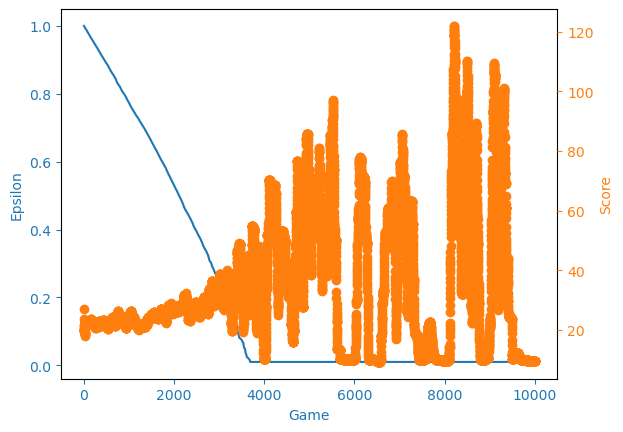

In [7]:
filename = "cartpole_naive_dqn.png"
x = [i + 1 for i in range(n_games)]
plot_learning_curve(x, scores, eps_history, filename)